In [2]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})

Populating the interactive namespace from numpy and matplotlib


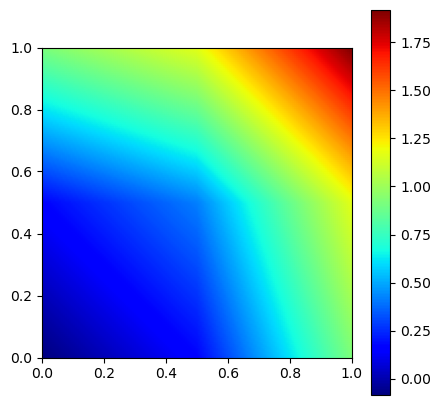

AssertionError: Unable to derive further dofs.

In [7]:
deg=1
kvs = [2 * (bspline.make_knots(1, 0.0, 1.0, deg),)]
geos = [geometry.unit_square()]
patches = [(k, g) for k, g in zip(kvs,geos)]
M = topology.PatchMesh(patches)
M.h_refine();
MP = assemble.Multipatch(M, automatch=True)
u1 = MP.L2projection(lambda x,y: x**2+y**2)
# MP.mesh.draw(plt.figure())
# axis('scaled');
MP.plot(u1)
MP.patch_refine({},p_ref=15, return_P=False)
# MP.mesh.draw(plt.figure())
# axis('scaled');
#MP.plot(P@u1)

In [10]:
MP.numdofs

49

In [7]:
allkey = set().union(A,B)

In [8]:
allkey

{0, 1, 4}

In [60]:
MP.mesh.patches

[(((KnotVector(array([0.00, 0.00, 0.25, 0.50, 0.50]), 0),
    KnotVector(array([0.00, 0.00, 0.25, 0.50, 0.50]), 0)),
   <pyiga.bspline.BSplineFunc at 0x7ffb0c2e95e0>),
  ([0, 4], [6, 7], [0, 6], [4, 7])),
 (((KnotVector(array([0.00, 0.00, 0.25, 0.50, 0.50]), 0),
    KnotVector(array([0.50, 0.50, 0.75, 1.00, 1.00]), 0)),
   <pyiga.bspline.BSplineFunc at 0x7ffb0c2e91f0>),
  ([4, 1], [7, 8], [4, 7], [1, 8])),
 (((KnotVector(array([0.50, 0.50, 0.75, 1.00, 1.00]), 0),
    KnotVector(array([0.00, 0.00, 0.25, 0.50, 0.50]), 0)),
   <pyiga.bspline.BSplineFunc at 0x7ffb0c2e9340>),
  ([6, 7], [2, 5], [6, 2], [7, 5])),
 (((KnotVector(array([0.50, 0.50, 0.75, 1.00, 1.00]), 0),
    KnotVector(array([0.50, 0.50, 0.75, 1.00, 1.00]), 0)),
   <pyiga.bspline.BSplineFunc at 0x7ffb0c282b80>),
  ([7, 8], [5, 3], [7, 5], [8, 3]))]

In [59]:
MP.reset()

/home/wolfman/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:230: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


AssertionError: No partition of unity.

In [28]:
deg=3
kvs1 = bspline.make_knots(2,0.0,1.0,deg)
kvs2 =  bspline.make_knots(3,0.0,1.0,deg+1)
P = bspline.prolongation(kvs1,kvs2)

In [29]:
P.A

array([[1.00, 0.00, 0.00, 0.00, 0.00],
       [0.50, 0.50, 0.00, -0.00, 0.00],
       [-0.12, 0.92, 0.19, 0.01, -0.01],
       [0.03, -0.05, 1.03, -0.05, 0.03],
       [-0.01, 0.01, 0.19, 0.92, -0.12],
       [0.00, -0.00, 0.00, 0.50, 0.50],
       [0.00, 0.00, 0.00, 0.00, 1.00]])

In [2]:
def drawSkeleton(MP):
    for (p,b,_),(_,_,_),_ in MP.intfs:
        ax,sd=assemble.int_to_bdspec(b)
        geo=MP.mesh.geos()[p]
        kvs=MP.mesh.kvs()[p]
        grid=np.linspace(geo.support[(ax+1)%2][0], geo.support[(ax+1)%2][1],kvs[(ax+1)%2].numdofs)
        if (p,b) == (4,1) or (p,b)==(5,3): grid=grid[1:-1]
        if ax==0:
            Z = geo.eval(grid,np.array([geo.support[0][sd]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd]]),grid)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs()[p], MP.mesh.geos()[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)

In [6]:
2*(bspline.make_knots(2,0,1,2),)

(KnotVector(array([0. , 0. , 0. , 0.5, 1. , 1. , 1. ]), 2),
 KnotVector(array([0. , 0. , 0. , 0.5, 1. , 1. , 1. ]), 2))

In [9]:
patches=[(2*(bspline.make_knots(2,0,1,2),),geometry.unit_square())]
M = topology.PatchMesh(patches)
M.split_patches();
#M.refine({0:None});
M.split_patches({0:None});
M.refine({0:None});
MP=assemble.Multipatch(M, automatch=True)

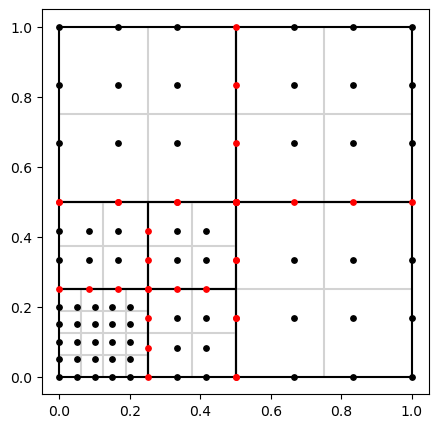

In [10]:
MP.mesh.draw(patch_idx=False)
drawInterior(MP,r=0)
drawSkeleton(MP)

In [6]:
kv1 ,kv2 = bspline.KnotVector(np.array([0.0,0.0,0.25,0.5,0.5]),1), bspline.KnotVector(np.array([0.0,0.0,0.5,0.7,0.8,0.9,1.0,1.0]),1)
bspline.prolongation(kv2,kv1).A

array([[1. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. ]])

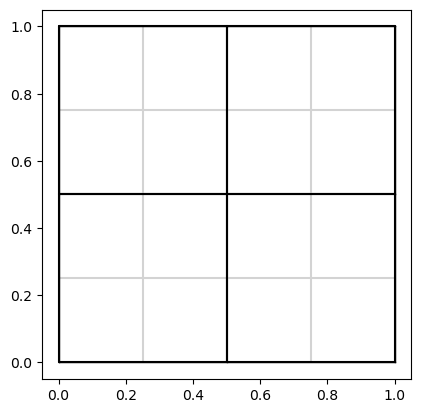

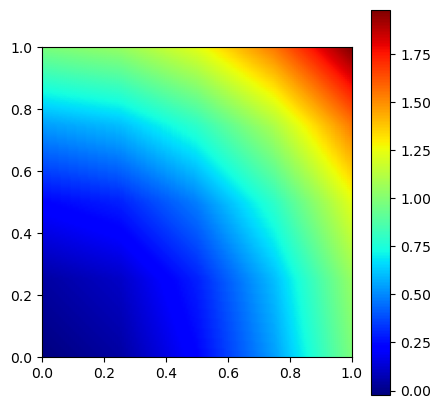

0


TypeError: 'dict_keys' object is not subscriptable

In [2]:
deg=2
kvs = [2 * (bspline.make_knots(1, 0.0, 1.0, deg),)]
geos = [geometry.unit_square()]
patches = [(k, g) for k, g in zip(kvs,geos)]
M = topology.PatchMesh(patches)
M.split_patches();
MP = assemble.Multipatch(M, automatch=True)
u1 = MP.L2projection(lambda x,y: x**2+y**2)
MP.mesh.draw(plt.figure())
axis('scaled');
MP.plot(u1)
P=MP.patch_refine({0:None,1:-1,2:-1,3:None},p_ref=deg+1, return_P=True)
MP.mesh.draw(plt.figure())
axis('scaled');
MP.plot(P@u1)

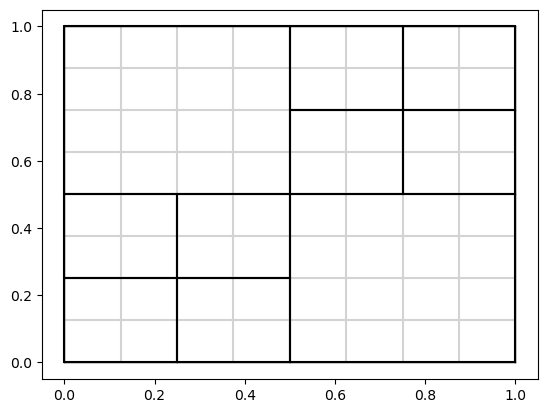

In [4]:
M.draw(plt.figure())

In [5]:
M.patches

[(((KnotVector(array([0.   , 0.   , 0.125, 0.25 , 0.25 ]), 1),
    KnotVector(array([0.   , 0.   , 0.125, 0.25 , 0.25 ]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f07983573a0>),
  ([0, 9], [11, 12], [0, 11], [9, 12])),
 (((KnotVector(array([0.   , 0.   , 0.125, 0.25 , 0.375, 0.5  , 0.5  ]), 1),
    KnotVector(array([0.5  , 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.   ]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f079bfcaf40>),
  ([4, 1], [7, 14, 8], [4, 13, 7], [1, 8])),
 (((KnotVector(array([0.5  , 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.   ]), 1),
    KnotVector(array([0.   , 0.   , 0.125, 0.25 , 0.375, 0.5  , 0.5  ]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f079bfcad00>),
  ([6, 10, 7], [2, 5], [6, 2], [7, 16, 5])),
 (((KnotVector(array([0.5  , 0.5  , 0.625, 0.75 , 0.75 ]), 1),
    KnotVector(array([0.5  , 0.5  , 0.625, 0.75 , 0.75 ]), 1)),
   <pyiga.bspline.BSplineFunc at 0x7f0798419dc0>),
  ([7, 14], [16, 17], [7, 16], [14, 17])),
 (((KnotVector(array([0.   , 0.   , 0.125, 0.25 , 0.25 ]),